In [12]:
!wget "http://personal.ik.itba.edu.ar/~jacoby/Image%20Processing/Teoria/Clase7/pic/barraxx.bmp"
!wget "http://personal.ik.itba.edu.ar/~jacoby/Image%20Processing/Teoria/Clase7/pic/pru2old.bmp"
!wget "http://personal.ik.itba.edu.ar/~jacoby/Image%20Processing/Teoria/Clase7/pic/BDBOB.jpg"
!wget "http://personal.ik.itba.edu.ar/~jacoby/Image%20Processing/Teoria/Clase2/lena.png"

import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from scipy import linalg

--2020-10-13 03:00:48--  http://personal.ik.itba.edu.ar/~jacoby/Image%20Processing/Teoria/Clase7/pic/barraxx.bmp
Resolving personal.ik.itba.edu.ar (personal.ik.itba.edu.ar)... 190.104.250.125
Connecting to personal.ik.itba.edu.ar (personal.ik.itba.edu.ar)|190.104.250.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600056 (586K) [image/x-ms-bmp]
Saving to: ‘barraxx.bmp.1’

barraxx.bmp.1       100%[===================>] 585.99K   641KB/s    in 0.9s    

2020-10-13 03:00:49 (641 KB/s) - ‘barraxx.bmp.1’ saved [600056/600056]

--2020-10-13 03:00:49--  http://personal.ik.itba.edu.ar/~jacoby/Image%20Processing/Teoria/Clase7/pic/pru2old.bmp
Resolving personal.ik.itba.edu.ar (personal.ik.itba.edu.ar)... 190.104.250.125
Connecting to personal.ik.itba.edu.ar (personal.ik.itba.edu.ar)|190.104.250.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251080 (245K) [image/x-ms-bmp]
Saving to: ‘pru2old.bmp.1’

pru2old.bmp.1       100%[==============

In [13]:

def doubleCirculant(mat,sh):
    original_shape = mat.shape
    
    padded = np.zeros(sh)
    padded[0:original_shape[0],0:original_shape[1]] = mat
    
    circulants = np.zeros((sh[0],sh[1],sh[1]))
    for i,v in enumerate(padded):
        aux = np.zeros(sh[1])
        aux[0] = v[0]
        circulants[i] = linalg.toeplitz(v,aux)

    totalSize = sh[0] * sh[1]
    final = np.zeros((totalSize,totalSize))
    for j in range(sh[0]):
        for i,mat in enumerate(circulants):
            x,y = mat.shape
            if( (i+j) < (x-1)):
                final[(i+j)*x:(i+j+1)*x,(j)*y:(j+1)*y] = mat
                
    return final

def normalize(img):
    mini = np.min(img)
    imgN = img - np.sign(mini)*np.abs(mini)
    imgN = imgN/np.max(imgN)
    return imgN

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

El MSE contra la imagen blurreada y con ruido aditivo es: 0.027033034065019793


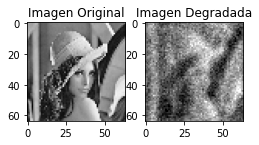

In [14]:
img = cv2.imread("lena.png",0)
or_row,or_col= img.shape

img = cv2.resize(img,(64,64))
img = normalize(img)
row,col= img.shape

#Definimos los filtros de blurring y high pass para la regularizacion
C=np.zeros((col,row))
Csmall=np.array([[0,-0.25,0],[-0.25, 1, -0.25],[0,-0.25,0]])
nb = C.shape[0]
na = Csmall.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb // 2) + (na // 2)+1
C[lower:upper, lower:upper] = Csmall

blurr_size = 5
H=np.zeros(img.shape)
lpass=np.ones((blurr_size,blurr_size))/blurr_size**2
nb = H.shape[0]
lower = (nb) // 2 - (blurr_size // 2)
upper = (nb // 2) + (blurr_size // 2)+1
H[lower:upper, lower:upper] = lpass

#Calculamos las matrices block circulant
C_double = doubleCirculant(Csmall,img.shape)
H_double = doubleCirculant(lpass,img.shape)
#print(H_double, C_double)

#Degradamos la imagen
HLP = np.fft.fft2(np.fft.ifftshift(H))
f = np.fft.fft2(img)
imgLP = np.abs(np.fft.ifft2(np.multiply(f,HLP)))

noise =  np.random.normal(loc=0, scale=0.1, size=img.shape)
g = imgLP + noise
g_flatten = g.flatten().reshape(row*col,1)


#Muestro las imagenes
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Imagen Original")
ax1.imshow(img*255, cmap='gray', vmin=0, vmax=255)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Imagen Degradada")
ax2.imshow(g*255, cmap='gray', vmin=0, vmax=255)

print('El MSE contra la imagen blurreada y con ruido aditivo es:',mse(img,g))

#Calculamos la constante para Tikhonov-Miller
alfa=np.power(noise,2).sum()/np.power(img,2).sum()

mod_H = np.matmul(np.transpose(H_double),H_double)
mod_C = np.matmul(np.transpose(C_double),C_double)